In [2]:
%env OPENCV_IO_ENABLE_OPENEXR=1
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from PIL import Image
import torch
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt
from inference_pytorch import PyTorchPipeline
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
from attack.pytorch_auto_drive.utils.lane_det_utils import lane_as_segmentation_inference
from lanefitting import get_offset_center, Camera
from config import *

def get_ipm_matrix(cam, image):
    cam_height = 50.0
    x_offset = 35.0 # in driving direction

    outputRes = (int(2 * cam.config["py"]), int(2 * cam.config["px"]))
    dx = outputRes[1] / cam.config["fx"] * cam_height
    dy = outputRes[0] / cam.config["fy"] * cam_height
    pxPerM = (outputRes[0] / dx, outputRes[1] / dy)


    # setup mapping from street/top-image plane to world coords
    shift = (outputRes[0] / 2.0, outputRes[1] / 2.0) # was (outputRes[0] / 2.0, outputRes[1] / 2.0)
    shift = shift[0] + x_offset * pxPerM[0], shift[1] - cam.config["XCam"] * pxPerM[1]
    M = np.array([[1.0 / pxPerM[1], 0.0, -shift[1] / pxPerM[1]], [0.0, -1.0 / pxPerM[0], shift[0] / pxPerM[0]], [0.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

    ipm = np.linalg.inv(cam.P.dot(M))
    return ipm

config_800x288 = {
    'fx': 692.82,
    'fy': 692.82, 
    'px': 400.0, 
    'py': 144.0, 
    'yaw': 90.0, 
    'pitch': 0.0, 
    'roll': 0.0, 
    'XCam': 0.0, 
    'YCam': 0.0, 
    'ZCam': 1.5
}
cam = Camera(config_800x288)

env: OPENCV_IO_ENABLE_OPENEXR=1


c:\Users\alexa\.conda\envs\pad11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
INFO:art.config:set ART_DATA_PATH to C:\Users\alexa\.art\data


INFO:art.estimators.classification.pytorch:Inferred 4 hidden layers on PyTorch classifier.


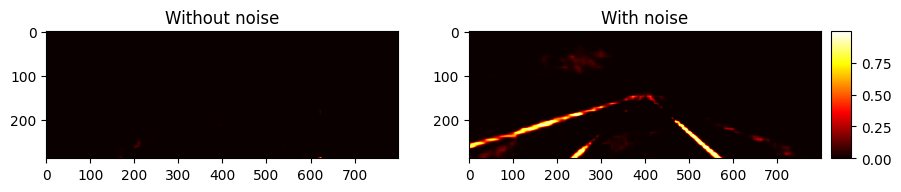

Offset center base model: None
Offset center trained model: 1.8682


In [22]:

model = "erfnet"
image = cv2.imread("single_frame_eval.exr", cv2.IMREAD_UNCHANGED)
# image = cv2.imread("erfnet_280.exr", cv2.IMREAD_UNCHANGED) # use this for erfnet and disable patching
image_size = image.shape[:2][::-1]
model_in = image.transpose(2, 0, 1)#.astype(np.float32) / 255.0
TARGET=np.load("../attack/targets/right_new.npy", allow_pickle=True).item()

pipeline_base = PyTorchPipeline(targeted=True, patch_size=(80, 80), 
                                        max_iterations=400,
                                        model=model)


def get_probmap_images(probmaps, image_size):
    prob_maps = torch.nn.functional.interpolate(probmaps['out'], 
                                                size=(image_size[1], image_size[0]), mode='bilinear', align_corners=True)
    prob_maps_softmax = prob_maps.detach().clone().softmax(dim=1)
    
    merged = np.zeros_like(prob_maps[0][1].detach().cpu().numpy())
    merged_softmax = np.zeros_like(prob_maps_softmax[0][1].detach().cpu().numpy())

    for i, lane in enumerate(prob_maps[0]):
        if i == 0: # skip first iteration (background class)
            continue
        pred = lane.detach().cpu().numpy()
        pred_softmax = prob_maps_softmax[0][i].detach().cpu().numpy()
        merged = np.maximum(merged, pred)
        merged_softmax = np.maximum(merged_softmax, pred_softmax)

    im = merged
    im_softmax = merged_softmax

    return im, im_softmax

model_in = torch.from_numpy(model_in).unsqueeze(0).to(pipeline_base.device)
patch = pipeline_base.attack.generate(x=model_in.cpu().numpy(), y=TARGET)[0]
patch_cuda= torch.from_numpy(patch).to(pipeline_base.device)

x_1, y_1 = pipeline_base.patch_location
x_2, y_2 = x_1 + patch.shape[2], y_1 + patch.shape[1]
model_in[0][:, y_1:y_2, x_1:x_2] = patch_cuda

results = pipeline_base.model(model_in)

model_in = image.transpose(2, 0, 1)#.astype(np.float32) / 255.0
model_in = torch.from_numpy(model_in).unsqueeze(0).to(pipeline_base.device)
model_in[0][:, y_1:y_2, x_1:x_2] = patch_cuda

temp = model_in[0].cpu().numpy()
noise = np.random.normal(0, 0.025, (image.shape[2], image.shape[0], image.shape[1]))
temp += noise
temp = np.clip(temp, 0, 1)

model_in = torch.from_numpy(temp).unsqueeze(0).to(pipeline_base.device)

results_noise = pipeline_base.model(model_in)

keypoints = lane_as_segmentation_inference(
        None,
        results,
        [input_sizes, input_sizes],
        gap,
        ppl,
        thresh,
        dataset,
        max_lane,
        forward=False,  # already called model
    )[0]

keypoints_noise = lane_as_segmentation_inference(
        None,
        results_noise,
        [input_sizes, input_sizes],
        gap,
        ppl,
        thresh,
        dataset,
        max_lane,
        forward=False,  # already called model
    )[0]
ipm_small = get_ipm_matrix(cam, image)
offset_center, _, _ = get_offset_center(
    keypoints, (image_size[0], image_size[1]), ipm_small
)
offset_center_noise, _, _ = get_offset_center(
    keypoints_noise, (image_size[0], image_size[1]), ipm_small
)

im, im_softmax = get_probmap_images(results, image_size)
im_trained, im_softmax_trained = get_probmap_images(results_noise, image_size)

# show im side by side and softmax in the next line side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0, 0].imshow(im, cmap='hot')
ax[0].set_title('Without noise')
# ax[0, 1].imshow(im_trained, cmap='hot')
ax[1].set_title('With noise')
ax[0].imshow(im_softmax, cmap='hot')
i = ax[1].imshow(im_softmax_trained, cmap='hot')
cax = fig.add_axes([ax[1].get_position().x1+0.01,ax[1].get_position().y0,0.02,ax[1].get_position().height])
plt.colorbar(i, cax=cax)


plt.savefig(f"probmaps_defence_gda_{model}.pdf", format="pdf", bbox_inches="tight")

plt.show()

print(f"Offset center base model: {offset_center}")
print(f"Offset center trained model: {offset_center_noise}")
